### Importing Required Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

### Loading and Inspecting Data

In [3]:

slot = pd.read_csv("navy_slot_results.csv")
nafi = pd.read_csv("navy_nafi_reimbursements.csv")

print("Slot DataFrame Shape:", slot.shape)
print("NAFI DataFrame Shape:", nafi.shape)

display(slot.head())
display(nafi.head())

Slot DataFrame Shape: (12, 12)
NAFI DataFrame Shape: (12, 12)


,Country,Installation,FY16,FY17,FY18,FY19,FY20 thru SEP,ANNUALIZED FY20,FY21 thru SEP,ANNUALIZED FY21,FY22 thru SEP,ANNUALIZED FY22
0,Korea,Chin Hae $,180813.56,107702.89,186026.95,178352.1,357443.06,357443.06,375058.45,375058.45,400476.40,400476.40
1,Malaysia,Singapore,21449.75,209637.55,222577.00,306888.0,33112.95,33112.95,-30.50,-30.50,59631.00,59631.00
2,Japan,Okinawa,482923.16,409981.09,380989.25,395305.7,280698.30,280698.30,389365.20,389365.20,384308.95,384308.95
3,Japan,New Sanno Hotel,927183.13,866641.41,888156.30,902217.9,651836.10,651836.10,367350.55,367350.55,971662.15,971662.15
4,Japan,Atsugi,1178216.09,1286398.70,1139178.40,1364078.3,1083616.25,1083616.25,1496235.90,1496235.90,1084112.55,1084112.55


,Country,Installation,FY16,FY17,FY18,FY19,FY20 thru SEP,ANNUALIZED FY20,FY21 thru SEP,ANNUALIZED FY21,FY22 thru SEP,ANNUALIZED FY22
0,Korea,Chin Hae $,123795.80,74906.95,130218.85,128157.50,247089.30,247089.30,276261.70,276261.70,277002.15,277002.15
1,Malaysia,Singapore,15014.80,146746.35,155803.95,214821.70,23179.05,23179.05,0.00,NaN,41720.35,41720.35
2,Japan,Okinawa,387932.90,326327.10,302532.15,317370.75,226868.40,226868.40,314512.55,314512.55,323246.40,323246.40
3,Japan,New Sanno Hotel,741316.35,696355.30,703721.60,724738.45,517065.95,517065.95,293880.40,293880.40,785196.45,785196.45
4,Japan,Atsugi,935369.00,1026505.95,909859.05,1091262.75,870871.05,870871.05,1193010.85,1193010.85,867289.85,867289.85


### Data Cleaning and Preparation

In [4]:
def clean_data(df):
    df = df.copy()
    # Clean up text and symbols
    df = df.applymap(lambda x: str(x).strip().replace("$", "").replace(",", "") if isinstance(x, str) else x)
    # Remove duplicate rows
    df.drop_duplicates(inplace=True)

    # Identify fiscal-year columns (FY16, FY17, etc.)
    fy_cols = sorted(set([c.split()[0] for c in df.columns if c.startswith("FY")]))
    cleaned = df[["Country", "Installation"]].copy()

    # Compute mean for repeated FY columns (like 'FY20 thru SEP', 'ANNUALIZED FY20', etc.)
    for fy in fy_cols:
        cols = [c for c in df.columns if fy in c]
        vals = df[cols].apply(pd.to_numeric, errors="coerce")
        cleaned[fy] = vals.mean(axis=1, skipna=True)

    # Handle blanks
    cleaned = cleaned.replace(r'^\s*$', pd.NA, regex=True)
    cleaned["Country"] = cleaned["Country"].astype(str).str.strip()
    cleaned["Installation"] = cleaned["Installation"].astype(str).str.strip()
    return cleaned

# Read and clean both CSVs
nafi_raw = pd.read_csv("navy_nafi_reimbursements.csv")
slot_raw = pd.read_csv("navy_slot_results.csv")

nafi = clean_data(nafi_raw)
slot = clean_data(slot_raw)

print("✅ Cleaning complete.")
print(f"NAFI shape: {nafi.shape} | SLOT shape: {slot.shape}")
display(nafi.head())

✅ Cleaning complete.
NAFI shape: (12, 9) | SLOT shape: (12, 9)


C:\Users\NithyaPriya\AppData\Local\Temp\ipykernel_2688\3872191558.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().replace("$", "").replace(",", "") if isinstance(x, str) else x)
C:\Users\NithyaPriya\AppData\Local\Temp\ipykernel_2688\3872191558.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().replace("$", "").replace(",", "") if isinstance(x, str) else x)


,Country,Installation,FY16,FY17,FY18,FY19,FY20,FY21,FY22
0,Korea,Chin Hae,123795.80,74906.95,130218.85,128157.50,247089.30,276261.70,277002.15
1,Malaysia,Singapore,15014.80,146746.35,155803.95,214821.70,23179.05,0.00,41720.35
2,Japan,Okinawa,387932.90,326327.10,302532.15,317370.75,226868.40,314512.55,323246.40
3,Japan,New Sanno Hotel,741316.35,696355.30,703721.60,724738.45,517065.95,293880.40,785196.45
4,Japan,Atsugi,935369.00,1026505.95,909859.05,1091262.75,870871.05,1193010.85,867289.85



### Year-wise Total Revenue

In [5]:

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("crest")
def compute_totals(df):
    totals = df.drop(columns=["Country", "Installation"]).sum(skipna=True)
    totals_df = pd.DataFrame(totals).T
    totals_df.index = ["Total Revenue"]
    return totals_df

nafi_totals_df = compute_totals(nafi)
slot_totals_df = compute_totals(slot)


def format_currency(val):
    return f"$ {val:,.2f}" if pd.notna(val) else ""

nafi_display = nafi_totals_df.applymap(format_currency)
slot_display = slot_totals_df.applymap(format_currency)


print("NAFI REIMBURSEMENTS – TOTAL REVENUE SUMMARY")

display(nafi_display)


print("SLOT REVENUE – TOTAL REVENUE SUMMARY")

display(slot_display)





NAFI REIMBURSEMENTS – TOTAL REVENUE SUMMARY


C:\Users\NithyaPriya\AppData\Local\Temp\ipykernel_2688\261410679.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nafi_display = nafi_totals_df.applymap(format_currency)
C:\Users\NithyaPriya\AppData\Local\Temp\ipykernel_2688\261410679.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  slot_display = slot_totals_df.applymap(format_currency)


,FY16,FY17,FY18,FY19,FY20,FY21,FY22
Total Revenue,"$ 8,276,939.10","$ 8,764,155.40","$ 9,472,378.58","$ 10,024,239.50","$ 7,255,672.33","$ 8,718,997.61","$ 10,740,528.70"


SLOT REVENUE – TOTAL REVENUE SUMMARY


,FY16,FY17,FY18,FY19,FY20,FY21,FY22
Total Revenue,"$ 10,475,261.71","$ 11,079,277.64","$ 11,962,762.74","$ 12,578,122.68","$ 9,175,136.41","$ 10,821,985.90","$ 13,453,435.06"


## Exploratory Data Analysis (EDA)
### Year-wise Total Revenue

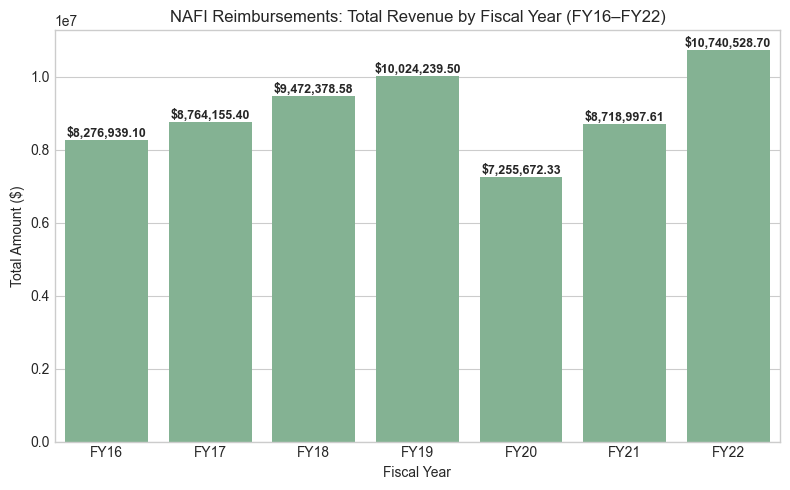

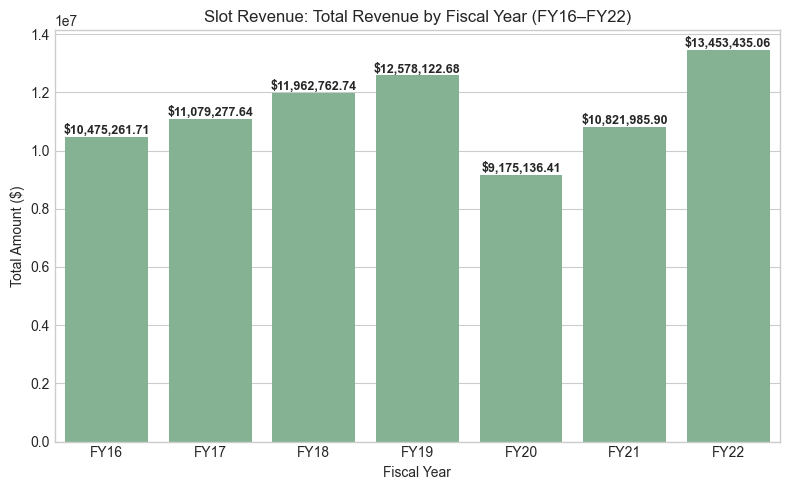

In [6]:
def plot_total_revenue(df, title):
    totals = df.drop(columns=["Country", "Installation"]).sum(skipna=True)
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=totals.index, y=totals.values)
    plt.title(f"{title}: Total Revenue by Fiscal Year (FY16–FY22)")
    plt.xlabel("Fiscal Year")
    plt.ylabel("Total Amount ($)")

    # Show exact full numbers with commas + 2 decimals
    for i, v in enumerate(totals.values):
        ax.text(i, v, f"${v:,.2f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

    plt.tight_layout()
    plt.show()

plot_total_revenue(nafi, "NAFI Reimbursements")
plot_total_revenue(slot, "Slot Revenue")

### Country-wise Total Revenue (FY16–FY22)

<Figure size 900x600 with 0 Axes>

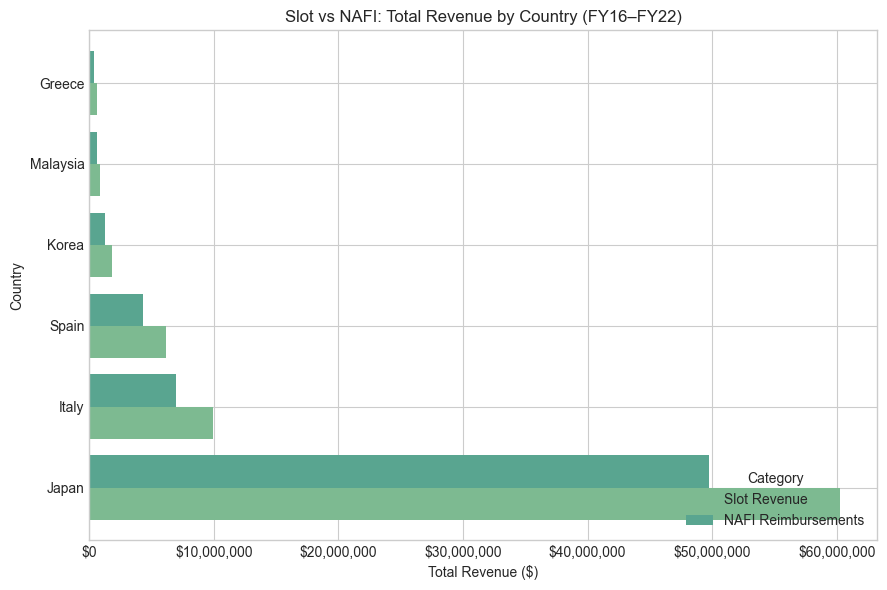

In [7]:

def plot_slot_vs_nafi_by_country(slot_df, nafi_df, show_currency=True):
    
    
    slot_country = (
        slot_df.groupby("Country")
        .sum(numeric_only=True)
        .drop(columns=["Country"], errors="ignore")
        .sum(axis=1)
    )
    nafi_country = (
        nafi_df.groupby("Country")
        .sum(numeric_only=True)
        .drop(columns=["Country"], errors="ignore")
        .sum(axis=1)
    )

    
    combined = pd.DataFrame({
        "Slot Revenue": slot_country,
        "NAFI Reimbursements": nafi_country
    }).fillna(0)

    
    combined["Total"] = combined["Slot Revenue"] + combined["NAFI Reimbursements"]
    combined = combined.sort_values("Total", ascending=False).drop(columns=["Total"])


    plt.figure(figsize=(9,6))
    combined.plot(kind="barh", figsize=(9,6), width=0.8)
    plt.title("Slot vs NAFI: Total Revenue by Country (FY16–FY22)")
    plt.xlabel("Total Revenue ($)")
    plt.ylabel("Country")
    plt.legend(title="Category", loc="lower right")

    
    import matplotlib.ticker as mtick
    if show_currency:
        plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

    plt.tight_layout()
    plt.show()


plot_slot_vs_nafi_by_country(slot, nafi)


## Time-Trend Analysis (FY16–FY22)

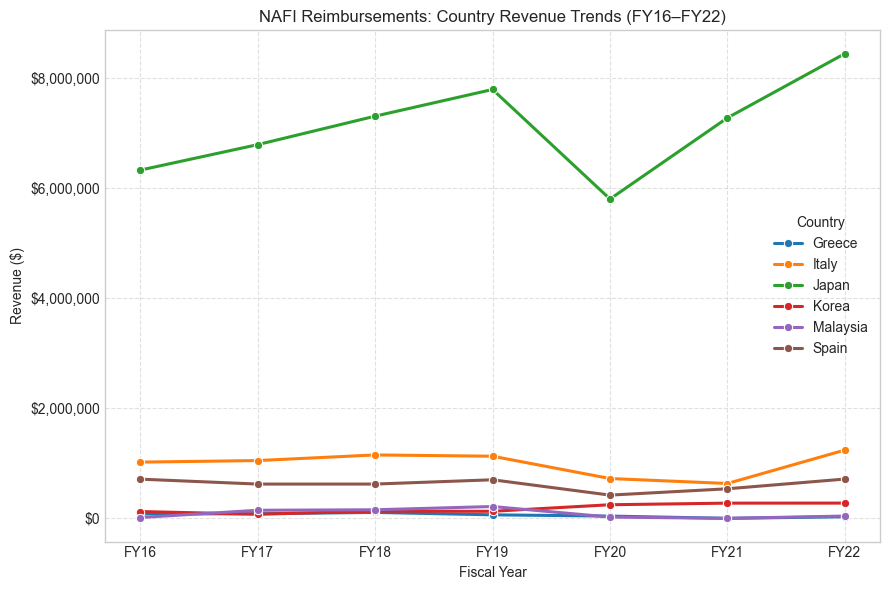

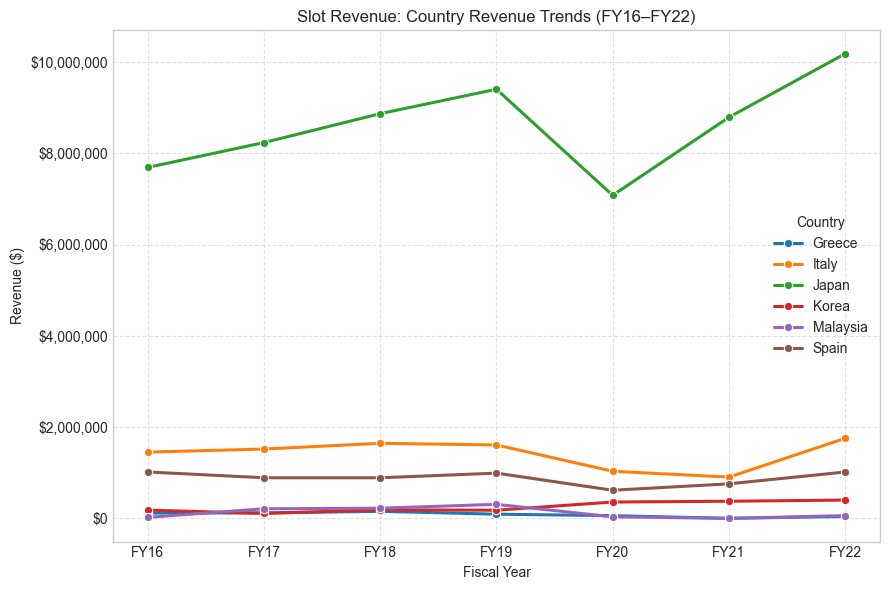

In [8]:


def plot_country_trends(df, title, show_currency=True):

    country_year = df.groupby("Country").sum(numeric_only=True)
    country_year = country_year.drop(columns=["Country"], errors="ignore")

    melted = country_year.reset_index().melt(
        id_vars="Country", var_name="Fiscal Year", value_name="Revenue"
    )

    plt.figure(figsize=(9,6))
    ax = sns.lineplot(
        data=melted,
        x="Fiscal Year",
        y="Revenue",
        hue="Country",
        palette="tab10",    
        linewidth=2.2,
        marker="o"
    )

    plt.title(f"{title}: Country Revenue Trends (FY16–FY22)")
    plt.xlabel("Fiscal Year")
    plt.ylabel("Revenue ($)")
    plt.legend(title="Country", loc="best")

    
    if show_currency:
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

    
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    
plot_country_trends(nafi, "NAFI Reimbursements")
plot_country_trends(slot, "Slot Revenue")

